In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [51]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INCO.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,2900.0,2950.0,2880.0,2900.0,2834.681641,8315300.0
1,2017-12-19,2940.0,2940.0,2890.0,2920.0,2854.230957,4371500.0
2,2017-12-20,2900.0,2900.0,2830.0,2850.0,2785.807617,10485500.0
3,2017-12-21,2870.0,2890.0,2840.0,2840.0,2776.032959,5395600.0
4,2017-12-22,2840.0,2850.0,2790.0,2800.0,2736.934082,4185500.0


In [52]:
# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [53]:
df.shape

(1494, 6)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1494 entries, 2017-12-18 to 2023-12-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1493 non-null   float64
 1   High       1493 non-null   float64
 2   Low        1493 non-null   float64
 3   Close      1493 non-null   float64
 4   Adj Close  1493 non-null   float64
 5   Volume     1493 non-null   float64
dtypes: float64(6)
memory usage: 81.7 KB


In [55]:
# Check missing values
df.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [56]:
df = df.dropna()

In [57]:
#MinMaxScaler
ms = MinMaxScaler()
df['Close_ms'] = ms.fit_transform(df[['Close']])


In [58]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [59]:
train, test = split_data(df['Close_ms'], 0.9) #90% Train

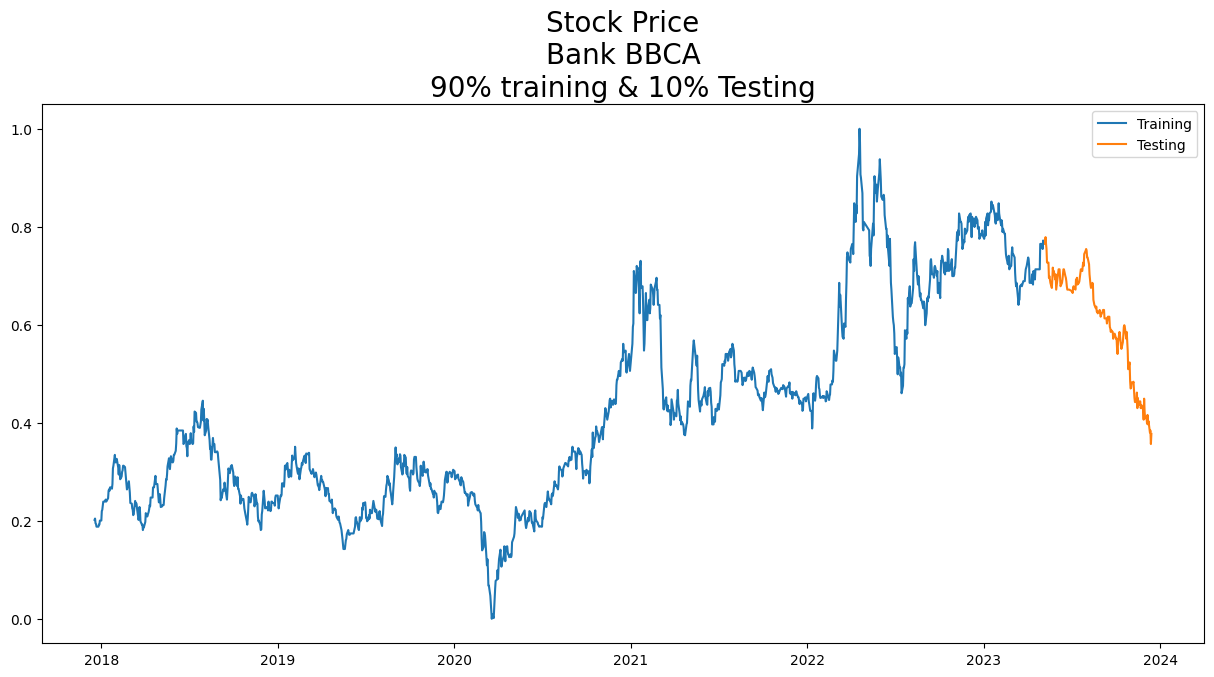

In [60]:
plt.figure(figsize=(15,7))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Testing'])
plt.title('Stock Price\nBank BBCA\n90% training & 10% Testing', fontsize=20)
plt.show()

In [61]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [62]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [63]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [64]:
# Callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

In [65]:
model = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [66]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118

In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

In [68]:
history = model.fit(X_train,
                    y_train,
                    epochs=125,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/125
11/11 [==============================] - 4s 87ms/step - loss: 0.1049 - mae: 0.4117 - val_loss: 0.1820 - val_mae: 0.5938
Epoch 2/125
11/11 [==============================] - 0s 10ms/step - loss: 0.1011 - mae: 0.4027 - val_loss: 0.1762 - val_mae: 0.5839
Epoch 3/125
11/11 [==============================] - 0s 10ms/step - loss: 0.0971 - mae: 0.3932 - val_loss: 0.1700 - val_mae: 0.5733
Epoch 4/125
11/11 [==============================] - 0s 10ms/step - loss: 0.0930 - mae: 0.3831 - val_loss: 0.1636 - val_mae: 0.5621
Epoch 5/125
11/11 [==============================] - 0s 7ms/step - loss: 0.0889 - mae: 0.3729 - val_loss: 0.1571 - val_mae: 0.5506
Epoch 6/125
11/11 [==============================] - 0s 9ms/step - loss: 0.0847 - mae: 0.3622 - val_loss: 0.1505 - val_mae: 0.5385
Epoch 7/125
11/11 [==============================] - 0s 9ms/step - loss: 0.0806 - mae: 0.3511 - val_loss: 0.1437 - val_mae: 0.5259
Epoch 8/125
11/11 [==============================] - 0s 8ms/step - loss: 0.0761

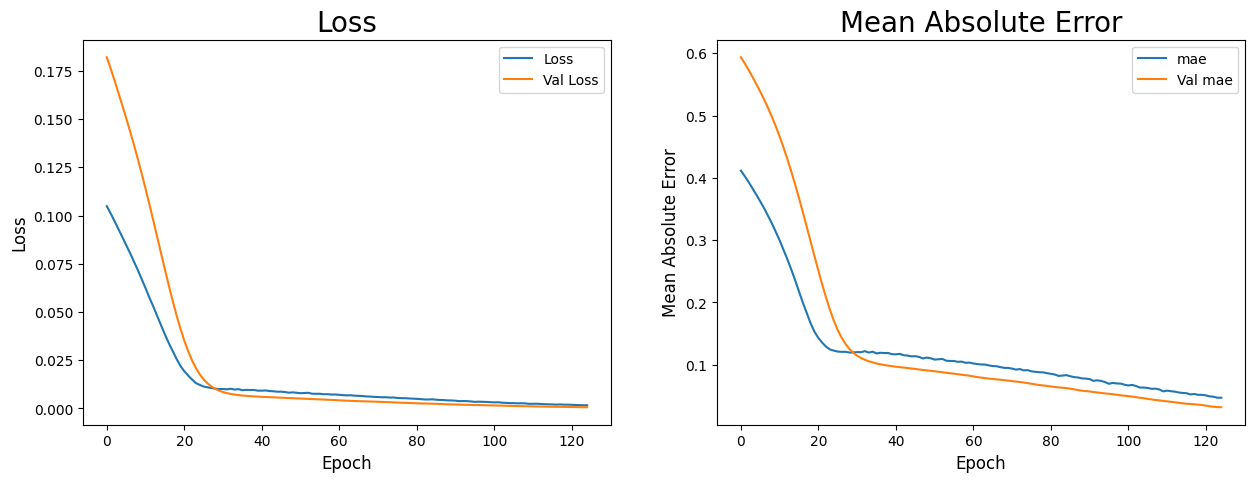

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

5/5 [==============================] - 1s 3ms/step


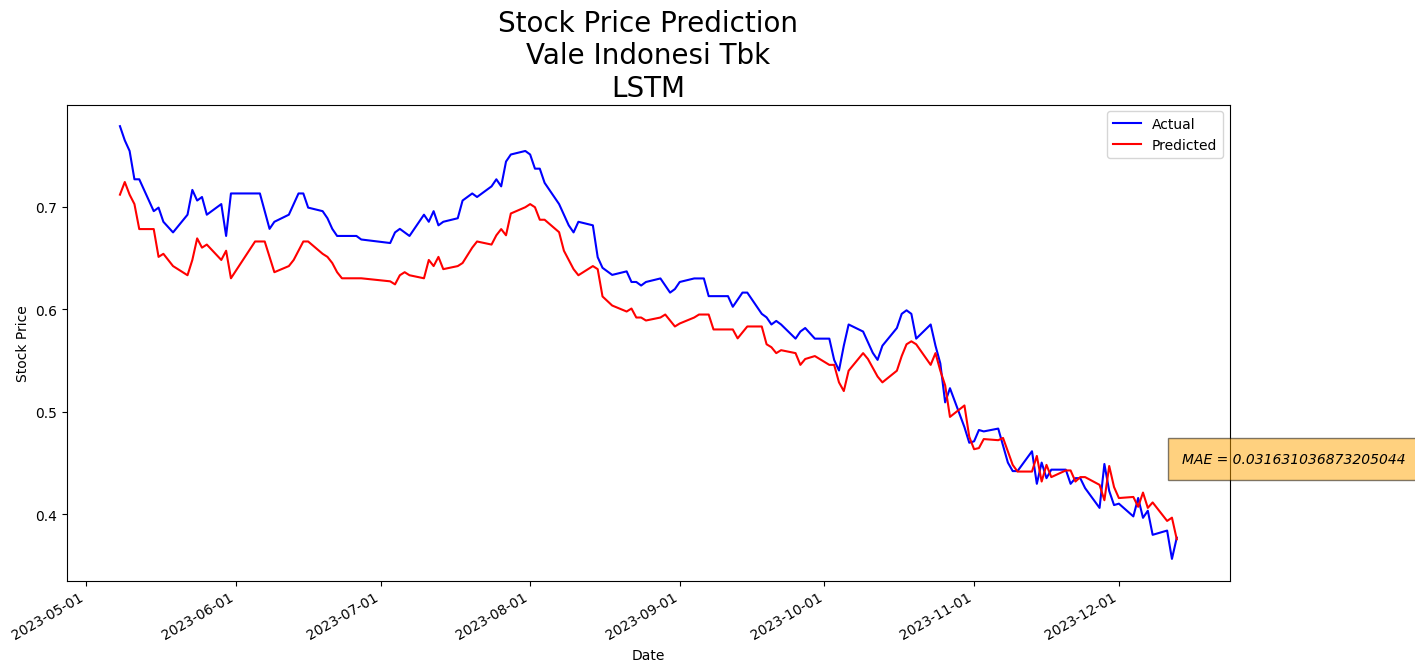

In [70]:
# Perform prediction on the test data
pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(test.index[:-1], y_test, color='blue', label='Actual')  # Exclude the last element to match the length
plt.plot(test.index[:-1], y_pred, color='red', label='Predicted')  # Exclude the last element to match the length
plt.text(test.index[149], 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nVale Indonesi Tbk\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [71]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAE: ', mae)
print('RSME: ', rmse)
print('MAPE: ', mape)

MAE:  0.031631036873205044
RSME:  0.035748472377625455
MAPE:  0.05015409879564839


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1492,) + inhomogeneous part.

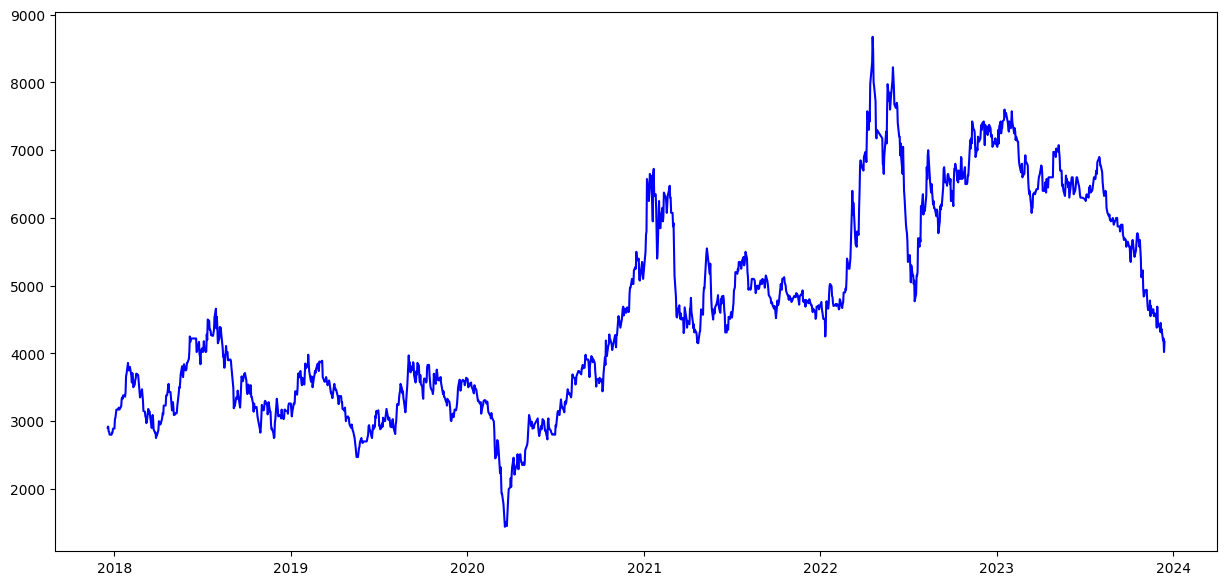

In [72]:
# Inverse transform the predicted values
y_pred_original = ms.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index[:-1], [None] * len(train.index) + list(y_pred_original), color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# Rotate x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1493,) and (1641,)

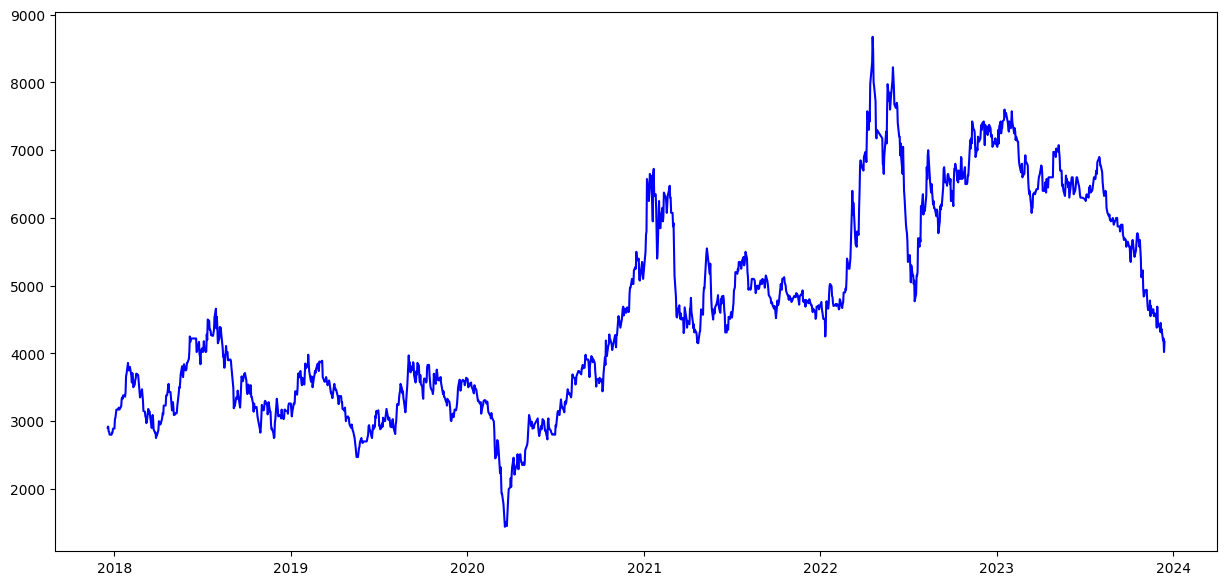

In [73]:
# Buat list kosong untuk menyimpan nilai-nilai yang akan digambarkan
predicted_values = [None] * len(df.index[:-1])  # Buat elemen-elemen "None" sebanyak yang dibutuhkan

# Tambahkan nilai-nilai yang diprediksi ke list predicted_values
predicted_values += list(y_pred_original.flatten())  # Gunakan flatten() untuk mengubah array 2D menjadi 1D

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index, predicted_values, color='red', label='Predicted')  # Gunakan predicted_values yang sudah dibuat
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nVale Indonesia Tbk\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (1492,) and (1641,)

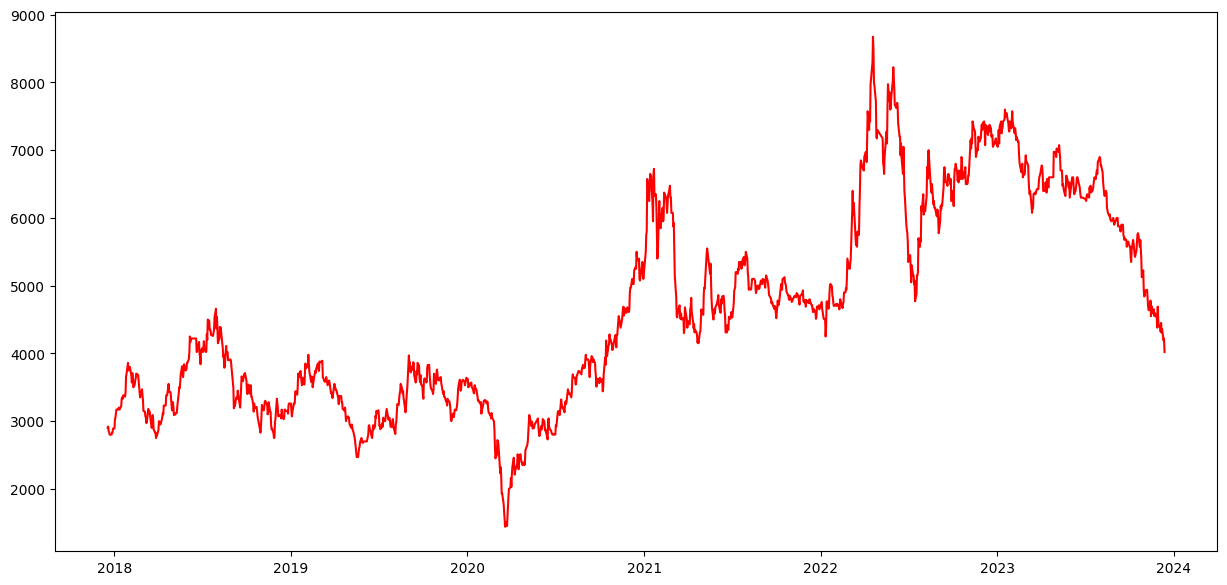

In [74]:
# Buat list indeks baru yang sesuai dengan panjang predicted_values
index_predicted = df.index[:-1]  # Menggunakan indeks yang sesuai dengan panjang predicted_values

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(index_predicted, df['Close'][:-1], color='red', label='Actual')  # Menggunakan index_predicted
plt.plot(index_predicted, predicted_values, color='red', label='Predicted')  # Menggunakan predicted_values
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nVale Indonesia Tbk\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


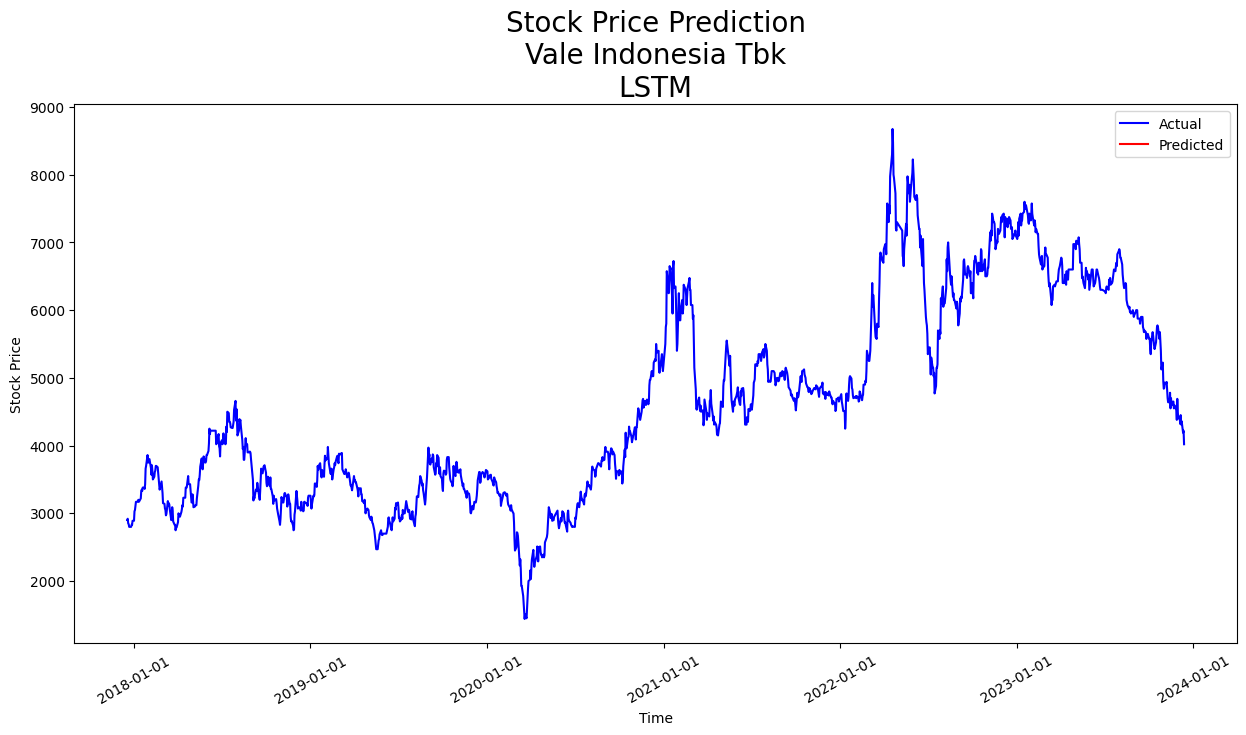

In [75]:
# Menyesuaikan panjang data sumbu x dan y
index_predicted = df.index[:-1]  # Gunakan indeks yang sesuai dengan panjang predicted_values

# Plot actual dan predicted prices
plt.figure(figsize=(15, 7))
plt.plot(index_predicted, df['Close'][:-1], color='blue', label='Actual')  # Gunakan index_predicted
plt.plot(index_predicted, predicted_values[:len(index_predicted)], color='red', label='Predicted')  # Gunakan predicted_values yang disesuaikan panjangnya
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nVale Indonesia Tbk\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=30)
plt.legend()
plt.show()


In [76]:
# Simpan nilai dari X_test terakhir untuk digunakan dalam prediksi
last_sequence = X_test[-1]

# Buat list untuk menyimpan prediksi
future_predictions = []

# Lakukan prediksi untuk 30 hari ke depan
for i in range(30):
    # Lakukan prediksi untuk satu langkah waktu ke depan
    next_pred = model.predict(last_sequence.reshape(1, 1, 1))[0][0]
    
    # Tambahkan prediksi ke list future_predictions
    future_predictions.append(next_pred)
    
    # Update last_sequence dengan nilai prediksi yang baru untuk digunakan pada iterasi berikutnya
    last_sequence = np.append(last_sequence[1:], next_pred)

# Ubah future_predictions menjadi numpy array
future_predictions = np.array(future_predictions)

# Tampilkan future_predictions
print("Prediksi untuk 30 hari ke depan:")
print(future_predictions)


1/1 [==============================] - 0s 28ms/step
Prediksi untuk 30 hari ke depan:
[0.3757799  0.39035693 0.40151486 0.41010186 0.41673774 0.42188206
 0.4258799  0.42899272 0.43141997 0.4333149  0.4347955  0.43595314
 0.4368589  0.4375678  0.43812278 0.4385574  0.43889785 0.4391646
 0.43937358 0.43953732 0.43966562 0.4397662  0.4398451  0.43990687
 0.43995526 0.4399932  0.44002295 0.4400463  0.4400646  0.44007897]


In [82]:
# Buat DataFrame untuk menyimpan prediksi
predictions_df = pd.DataFrame(future_predictions_denormalized, columns=["Predicted Price"])

# Tambahkan kolom tanggal untuk 30 hari ke depan
last_date = df.index[-1]  # Ambil tanggal terakhir dari data asli
date_range = pd.date_range(start=last_date, periods=30, freq='D')  # Buat rentang tanggal untuk 30 hari ke depan
predictions_df['Date'] = date_range

# Atur kolom tanggal sebagai indeks
predictions_df.set_index('Date', inplace=True)

# Tampilkan DataFrame prediksi
print("Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):")
print(predictions_df)

Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):
            Predicted Price
Date                       
2023-12-14      4158.767578
2023-12-15      4264.232422
2023-12-16      4344.959961
2023-12-17      4407.086914
2023-12-18      4455.097656
2023-12-19      4492.316406
2023-12-20      4521.241211
2023-12-21      4543.762207
2023-12-22      4561.323730
2023-12-23      4575.033203
2023-12-24      4585.745605
2023-12-25      4594.121094
2023-12-26      4600.674316
2023-12-27      4605.802734
2023-12-28      4609.818359
2023-12-29      4612.962891
2023-12-30      4615.425781
2023-12-31      4617.355957
2024-01-01      4618.867676
2024-01-02      4620.052246
2024-01-03      4620.980957
2024-01-04      4621.708496
2024-01-05      4622.279297
2024-01-06      4622.726074
2024-01-07      4623.076172
2024-01-08      4623.351074
2024-01-09      4623.565918
2024-01-10      4623.734863
2024-01-11      4623.867676
2024-01-12      4623.971191


In [83]:
# Denormalisasi future_predictions menggunakan objek MinMaxScaler (ms)
future_predictions_denormalized = ms.inverse_transform(future_predictions.reshape(-1, 1))

# Tampilkan future_predictions_denormalized
print("Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):")
print(future_predictions_denormalized)


Prediksi untuk 30 hari ke depan (Setelah Denormalisasi):
[[4158.7676]
 [4264.2324]
 [4344.96  ]
 [4407.087 ]
 [4455.0977]
 [4492.3164]
 [4521.241 ]
 [4543.762 ]
 [4561.3237]
 [4575.033 ]
 [4585.7456]
 [4594.121 ]
 [4600.6743]
 [4605.8027]
 [4609.8184]
 [4612.963 ]
 [4615.426 ]
 [4617.356 ]
 [4618.8677]
 [4620.0522]
 [4620.981 ]
 [4621.7085]
 [4622.2793]
 [4622.726 ]
 [4623.076 ]
 [4623.351 ]
 [4623.566 ]
 [4623.735 ]
 [4623.8677]
 [4623.971 ]]
